# Построение робастной линейной регрессии

### Теоретическая сводка

В анализе временных рядов задача построения тренда достаточно тривиальна. Исключением является наличие выбросов внутри ряда, поскольку удаление уровня ряда с аномальным значением нарушит требование равных интервалов между уровнями.

**Робастная линейная регрессия** предусматривает построение модели не на основе функционала среднеквадратичной ошибки MSE, значительно чувствительного к большим отклонениям, а с использованием средней абсолютной ошибки MAE:

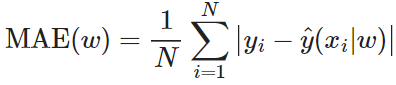

Поскольку такая функция не дифференцируема в нуле, ввиду невозможности использовать аналитический метод, для поиска оптимальных параметров $w$ используется метод численной оптимизации - **градиентный спуск**.

### Программная реализация

In [7]:
import numpy as np
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")

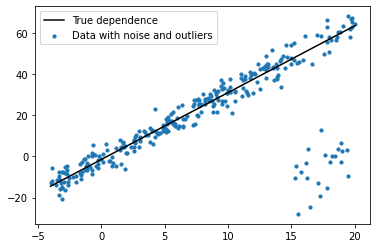

In [4]:
# инициализируем датасет с сильными выбросами

true_function = lambda x: 3.25 * x - 1.47
noize_function = lambda x: (
    np.random.normal(size=len(x)) * 4. +
    np.where(
        x < 15,
        0.,
        -60 + np.random.normal(size=len(x)) * 10
    ) * (np.random.uniform(size=len(x)) < 0.4).astype(int)
)
limits = (-4., 20.)

def generate_dataset(N=300):
    '''
    Генерирует датасет с сильным шумом.
    '''
    x = np.random.uniform(*limits, size=N)
    y = true_function(x) + noize_function(x)

    return x[:,None], y

X, y = generate_dataset()

x = np.linspace(*limits, 101)
plt.plot(x, true_function(x), c='black', label='True dependence')
plt.scatter(X, y, s=10, label='Data with noise and outliers')
plt.legend();

In [5]:
#Adding a constant feature in initial dataset

bias = np.ones(shape = (len(X), 1))
predictors = np.concatenate([X, bias], axis = 1)
weights = np.random.uniform(size=predictors.shape[1])
learning_rate = 0.1

#Implementation of the Gradient Descent with MAE loss function

errors = []
num_steps = 0

def robust_regression(predictors, weights, learning_rate=0.1, num_steps=100):
    """
    Запускает процесс оптимизации весов линейной регрессии
    на основе градиентного спуска с инициализированными весами
    weights, независимыми переменными predictors, шагом спуска learning_rate,
    и  количеством шагов num_steps.
    Возвращает историю обучения с весами, и MAE ошибкой.
    """
    
    while num_steps < 100:
        num_steps +=1
        gradient = np.sum(predictors * (np.sign(predictors.dot(weights) - y)).reshape(len(predictors),1) / len(predictors), axis=0)
        weights -= learning_rate*gradient
        MAE = np.sum(np.abs(y - weights@predictors.T))/len(predictors)
        errors.append([MAE, num_steps, weights])
    return errors

robust_regression(predictors, weights, learning_rate, num_steps=100)

min(errors)

[7.342415097199201, 100, array([ 3.13597351, -0.39263509])]

Text(0.5, 1.0, 'Learning curve')

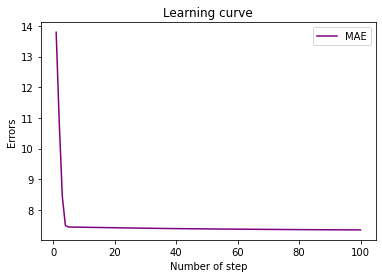

In [8]:
plt.plot(np.array(errors)[:, 1], np.array(errors)[:, 0], label = 'MAE', color = 'purple', linewidth = 1.5)
plt.legend()
plt.xlabel('Number of step')
plt.ylabel('Errors')
plt.title('Learning curve')

MSE regression coefficients:  [2.32375856] 1.2447412530878488
MAE regression coefficients:  [ 3.13597351 -0.39263509]


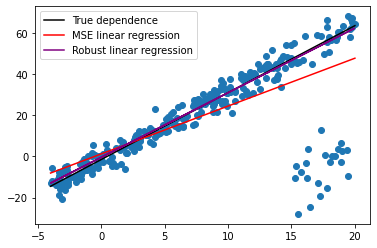

In [11]:
# Построим MSE линейную регрессию и сравним результат с робастной линейной регрессией

from sklearn.linear_model import LinearRegression

model = LinearRegression()
model.fit(X, y)

x = np.linspace(*limits, 101)
plt.plot(x, true_function(x), c='black', label='True dependence')
plt.scatter(X, y);
plt.plot(x, model.predict(x[:,None]), label='MSE linear regression', c = 'red')
plt.plot(X, min(errors)[2]@predictors.T, c='purple', label='Robust linear regression')
plt.legend()

print('MSE regression coefficients: ', model.coef_, model.intercept_)
print('MAE regression coefficients: ', min(errors)[2])

Очевидно, что робастная линейная регрессия получилась несмещённой, несмотря на обилие выбросов.